In [2]:
import os
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import igraph as ig
#import gseapy

In [3]:
from GmGM import GmGM
from utilities import shrink_per_col
from other_algs.EiGLasso import EiGLasso

In [4]:
import time

# Load Data

In [5]:
# Get data from:
# https://www.10xgenomics.com/resources/datasets/fresh-frozen-lymph-node-with-b-cell-lymphoma-14-k-sorted-nuclei-1-standard-2-0-0

# Load data
mudata = mu.read_10x_h5(
    os.path.join(
        "../data/10x-Genomics/",
        "lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5"
    )
)

mudata

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from ../data/10x-Genomics/lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5


/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 14566 × 146390
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	14566 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	14566 x 109789
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
rna = mudata["rna"]
rna.var_names_make_unique()

atac = mudata["atac"]
atac.var_names_make_unique()
mudata.update()


# Preprocess Data

In [7]:
# Add mitochondrial info
rna.var['mt'] = rna.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(
    rna,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

rna.obs["log_genes_by_counts"] = np.log10(
    rna.obs["n_genes_by_counts"] + 1
)

# Calculate median absolute deviation of n_genes_by_counts
med = np.median(rna.obs['log_genes_by_counts'])
mad = np.median(
    np.abs(
        rna.obs['log_genes_by_counts'] - med
    )
)

# Filter out cells with any mitochondrial genes
# Because this is a single-nucleus experiment, and we expect
# the mitochondria to be in the cytoplasm (not the nucleus),
# any presence is likely to be a technical artifact.
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x == 0)

# Filter out cells with too many or too few genes
# (Based on 3 median absolute deviations from the median)
mu.pp.filter_obs(
    rna,
    'log_genes_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Filter out low quality genes
#===#

rna.var["log_cells_by_counts"] = np.log10(
    rna.var["n_cells_by_counts"]+1
)
med = np.median(rna.var["log_cells_by_counts"])
mad = np.median(
    np.abs(
        rna.var["log_cells_by_counts"] - med
    )
)

# Filter out genes with less than 3 cells
mu.pp.filter_var(
    rna,
    'n_cells_by_counts',
    lambda x: x >= 3
)

# Filter out genes outside of 3 median absolute deviations
# Note that this won't do anything, all are within 3 MADs
mu.pp.filter_var(
    rna,
    'log_cells_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Normalize genes
#===#

sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# Find and label highly variable genes
sc.pp.highly_variable_genes(
    rna,
    min_mean=0.02,
    max_mean=4,
    min_disp=0.5
)

#===#
# Filter out low quality peaks
#===#

# Note, because we're using `scanpy`, our peaks
# will be referred to as "genes" here.
sc.pp.calculate_qc_metrics(
    atac,
    percent_top=None,
    log1p=False,
    inplace=True
)

atac.obs['log_total_counts'] = np.log10(
    atac.obs['total_counts']+1
)
atac.obs['log_genes_by_counts'] = np.log10(
    atac.obs['n_genes_by_counts']+1
)
atac.var['log_cells_by_counts'] = np.log10(
    atac.var['n_cells_by_counts']+1
)

# Filter out total_counts within 3 MADs of the median
med = np.median(atac.obs['log_total_counts'])
mad = np.median(np.abs(atac.obs['log_total_counts'] - med))
mu.pp.filter_obs(
    atac,
    'log_total_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

# Filter out n_genes_by_counts within 3 MADs of the median
med = np.median(atac.obs['log_genes_by_counts'])
mad = np.median(np.abs(atac.obs['log_genes_by_counts'] - med))
mu.pp.filter_obs(
    atac,
    'log_genes_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

# Filter out n_cells_by_counts within 3 MADs of the median
med = np.median(atac.var['log_cells_by_counts'])
mad = np.median(np.abs(atac.var['log_cells_by_counts'] - med))
mu.pp.filter_var(
    atac,
    'log_cells_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Normalize peaks
#===#

mu.atac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

# Find and label highly variable peaks ("genes")
sc.pp.highly_variable_genes(
    atac,
    min_mean=0.05,
    max_mean=1.5,
    min_disp=1
)

mudata.update()

In [8]:
mudata

MuData object with n_obs × n_vars = 13744 × 125884
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	2552 x 27489
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_genes_by_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	13551 x 98395
      obs:	'n_genes_by_counts', 'total_counts', 'log_total_counts', 'log_genes_by_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

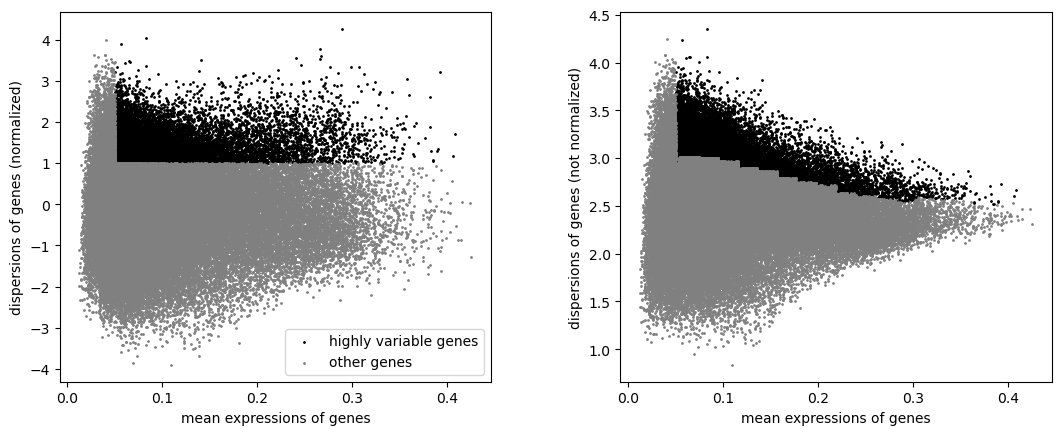

In [9]:
sc.pl.highly_variable_genes(atac)

In [10]:
cells_that_passed_both_tests = np.intersect1d(
    rna.obs_names,
    atac.obs_names
)

# We have to copy b/c can't call `filter_var` on a view :(
filtered_mudata = mudata[cells_that_passed_both_tests].copy()
filtered_mudata.var['highly_variable'] = \
    filtered_mudata.var['highly_variable'].values.to_numpy().astype(bool)

# # Grab just the highly variable genes and peaks
mu.pp.filter_var(
    filtered_mudata,
    'highly_variable',
    lambda x: x
)

In [11]:
filtered_mudata

MuData object with n_obs × n_vars = 2359 × 17835
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	2359 x 5350
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_genes_by_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	2359 x 12485
      obs:	'n_genes_by_counts', 'total_counts', 'log_total_counts', 'log_genes_by_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

In [12]:
cell_by_gene = filtered_mudata["rna"].X
cell_by_atac = filtered_mudata["atac"].X

# Experiment 1: GmGM: leiden, and tSNE and ensemble

In [13]:
start_time = time.time()
output = GmGM(
    {
        "RNA": cell_by_gene.toarray(),
        "ATAC": cell_by_atac.toarray()
    },
    {
        "RNA": ("cell", "gene"),
        "ATAC": ("cell", "peak")
    },
)
end_time = time.time()
print(f"GmGM took {end_time - start_time} seconds")

GmGM took 414.15946102142334 seconds


In [14]:
shrink_per_col(
    output,
    {
        "cell": 5,
        "gene": 5,
        "peak": 5
    },
    safe=False
)
pass

In [15]:
# taken from https://github.com/ftheberge/Ensemble-Clustering-for-Graphs
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part

ig.Graph.community_ecg = community_ecg

In [78]:
# Create cell graph
cell_graph = ig.Graph.Adjacency((output["cell"] + output["cell"].T) != 0).as_undirected()

# Do louvain clustering on cell graph
cell_graph.vs["louvain"] = [
    f"Cluster {cluster}"
    for cluster in cell_graph.community_multilevel().membership
]
filtered_mudata.obs["louvain"] = cell_graph.vs["louvain"]

# Leiden
cell_graph.vs["leiden"] = [
    f"Cluster {cluster}"
    for cluster in cell_graph.community_leiden(resolution=0.002).membership
]
filtered_mudata.obs["leiden"] = cell_graph.vs["leiden"]

# ECG
cell_graph.vs["ecg"] = [
    f"Cluster {cluster}"
    for cluster in cell_graph.community_ecg().membership
]
filtered_mudata.obs["ecg"] = cell_graph.vs["ecg"]

In [79]:
filtered_mudata["rna"].obs["louvain"] = cell_graph.vs["louvain"]
filtered_mudata["rna"].obs["leiden"] = cell_graph.vs["leiden"]
filtered_mudata["rna"].obs["ecg"] = cell_graph.vs["ecg"]

In [80]:
(filtered_mudata["rna"].obs["leiden"].value_counts() > 1).sum() / (filtered_mudata["rna"].obs["leiden"].value_counts() > 0).sum()

1.0

In [81]:
filtered_mudata["rna"].obs["leiden"].value_counts()

leiden
Cluster 0    1138
Cluster 1     471
Cluster 3     357
Cluster 2     259
Cluster 4     112
Cluster 6      15
Cluster 5       7
Name: count, dtype: int64

In [59]:
# First run PCA to ease computational load
sc.pp.pca(filtered_mudata['rna'], n_comps=30)
sc.pp.pca(filtered_mudata['atac'], n_comps=30)

# Find nearest neighbors (umap prep)
sc.pp.neighbors(filtered_mudata['rna'])
sc.pp.neighbors(filtered_mudata['atac'])

# Joint neighbor network construction
mu.pp.neighbors(filtered_mudata)

# Now, finally, UMAP
mu.tl.umap(filtered_mudata)

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


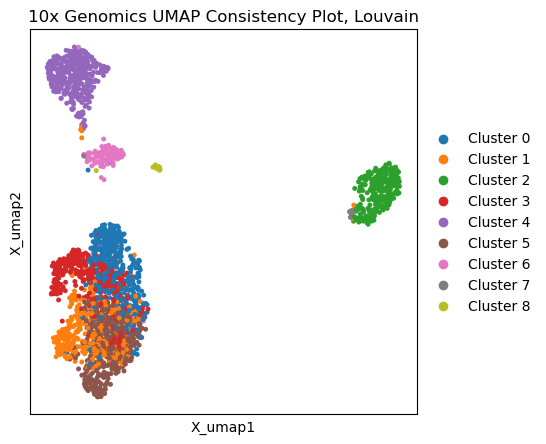

In [106]:
fig, ax = plt.subplots(figsize=(5, 5))
mu.pl.umap(
    filtered_mudata,
    color=["louvain"],
    ax=ax,
    title="10x Genomics UMAP Consistency Plot, Louvain"
)

In [107]:
fig.savefig("../out_figs/10x-umap-louvain.png")
fig.savefig("../out_figs/10x-umap-louvain.svg")
fig.savefig("../out_figs/10x-umap-louvain.pdf")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


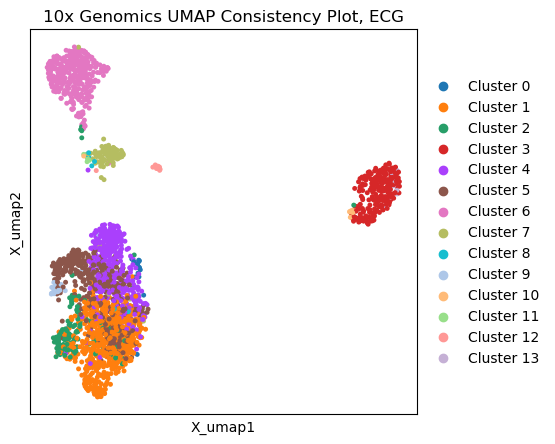

In [108]:
fig, ax = plt.subplots(figsize=(5, 5))
mu.pl.umap(
    filtered_mudata,
    color=["ecg"],
    ax=ax,
    title="10x Genomics UMAP Consistency Plot, ECG"
)

In [109]:
fig.savefig("../out_figs/10x-umap-ecg.png")
fig.savefig("../out_figs/10x-umap-ecg.svg")
fig.savefig("../out_figs/10x-umap-ecg.pdf")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


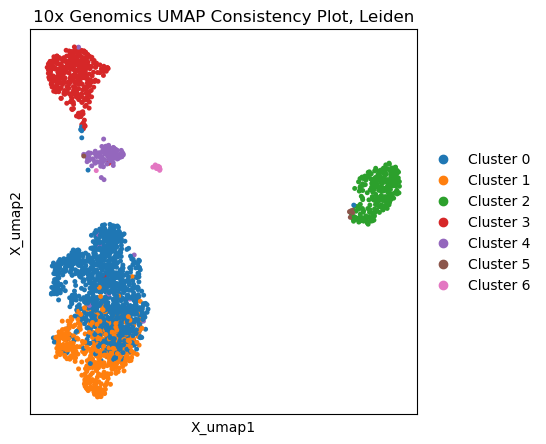

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))
mu.pl.umap(
    filtered_mudata,
    color=["leiden"],
    ax=ax,
    title="10x Genomics UMAP Consistency Plot, Leiden"
)

In [111]:
fig.savefig("../out_figs/10x-umap-leiden.png")
fig.savefig("../out_figs/10x-umap-leiden.svg")
fig.savefig("../out_figs/10x-umap-leiden.pdf")

In [112]:
sc.tl.tsne(filtered_mudata["rna"])

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


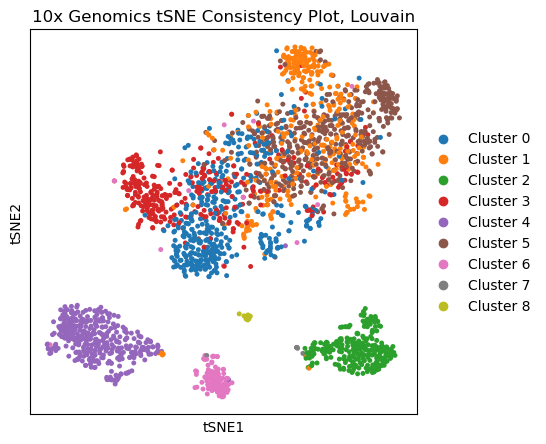

In [113]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.tsne(
    filtered_mudata["rna"],
    color=["louvain"],
    ax=ax,
    title="10x Genomics tSNE Consistency Plot, Louvain"
)

In [114]:
fig.savefig("../out_figs/10x-tsne-louvain.png")
fig.savefig("../out_figs/10x-tsne-louvain.svg")
fig.savefig("../out_figs/10x-tsne-louvain.pdf")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


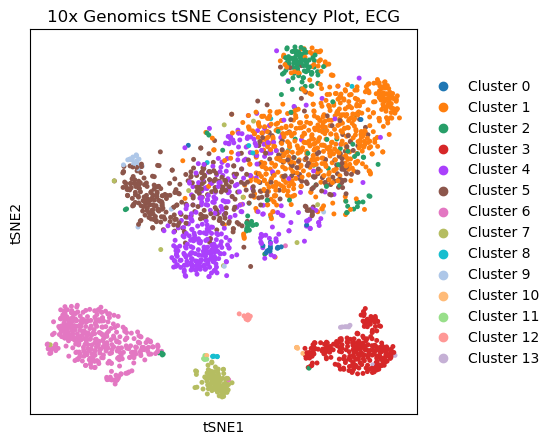

In [115]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.tsne(
    filtered_mudata["rna"],
    color=["ecg"],
    ax=ax,
    title="10x Genomics tSNE Consistency Plot, ECG"
)

In [116]:
fig.savefig("../out_figs/10x-tsne-ecg.png")
fig.savefig("../out_figs/10x-tsne-ecg.svg")
fig.savefig("../out_figs/10x-tsne-ecg.pdf")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


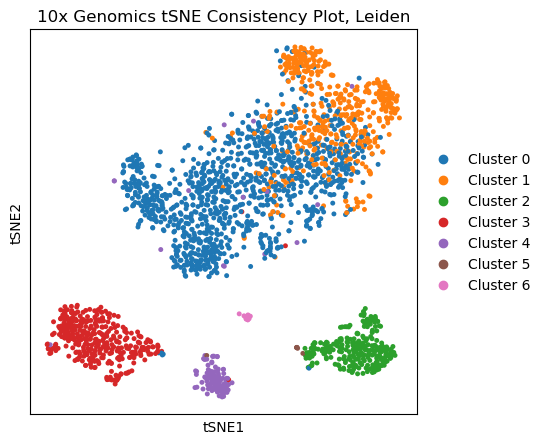

In [117]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.tsne(
    filtered_mudata["rna"],
    color=["leiden"],
    ax=ax,
    title="10x Genomics tSNE Consistency Plot, Leiden"
)

In [118]:
fig.savefig("../out_figs/10x-tsne-leiden.png")
fig.savefig("../out_figs/10x-tsne-leiden.svg")
fig.savefig("../out_figs/10x-tsne-leiden.pdf")